In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Read data from files
kodiak = pd.read_csv('data/kodiak.txt', sep="\s+", names=["Latitude","Longitude"])
dstns = pd.read_csv('data/dstns.txt', sep="\s+", names=["Year","Length","Females_juveniles","Females_Adult","Males"])
fleet = pd.read_csv('data/fleet.txt', sep="\s+", names=["Year","Vessels_register_fishing","Crab_catch","Weight_crab_catch","pot_lifts","Price_crab"])
fullness = pd.read_csv('data/fullness.txt', sep="\s+", names=["Year","Size","0%_fullness","1-29%_fullness","30-59%_fullness","60-89%_fullness","90-100%_fullness"])
survey = pd.read_csv('data/survey.txt', sep="\s+", names=["annee","district","station","pots","latitude","longitude","pre4","pre3","pre2","pre1","rmale","prmale","juvfemale","adultfemale"])
eggs = pd.read_csv('data/eggs.txt', sep="\s+", names=["annee","Nboeufs"])
celsius = pd.read_csv('data/celsius.txt', sep="\s+", names=["annee","mois","temp"])
catch = pd.read_csv('data/catch.txt', sep="\s+", names=["annee","district","Nbcapture","Nbcapturekg"])
salinite = pd.read_csv('data/salinity.txt', sep="\s+", names=["annee","mois","salinite"])

In [30]:
## Data manipulations

fleet["Meankg"] = fleet["Weight_crab_catch"] / fleet["Crab_catch"]
fleet["logprice"] = np.log(fleet["Price_crab"])


survey['price'] = survey['annee'].map(fleet.set_index('Year')['Price_crab'])
survey["legal_male"] = survey["rmale"] + survey["prmale"]
survey["all_male"] = survey[["pre4","pre3","pre2","pre1","rmale","prmale"]].sum(axis=1)
survey["all_female"] = survey["juvfemale"] + survey["adultfemale"]
survey["sexratio"] = survey["all_female"] / survey["all_male"]
survey["sexratio"].replace({0: np.nan, "NaN": np.nan, "Inf": np.nan}, inplace=True)

meanTemp = celsius.groupby('annee').temp.mean().reset_index()
eggs['temp'] = eggs["annee"].map(meanTemp.set_index('annee')['temp'])

merged_df = pd.merge(catch, fleet[['Year', 'Price_crab', 'Vessels_register_fishing', 'pot_lifts']], left_on='annee', right_on='Year', how='left')
catch['Price'] = merged_df['Price_crab']
catch['vessels'] = merged_df['Vessels_register_fishing']
catch['pieges'] = merged_df['pot_lifts']
catch["vessels"] = catch['annee'].map(fleet.set_index('Year')['Vessels_register_fishing'])
catch["pieges"] = catch['annee'].map(fleet.set_index('Year')['pot_lifts'])

catch["Pricekg"] = catch["Price"] / 0.45
catch["PoidsCrabs"] = catch["Nbcapturekg"] / catch["Nbcapture"]
catch["Meanprice1crab"] = catch["PoidsCrabs"] * catch["Pricekg"]

meansalinity = salinite.groupby('annee').salinite.mean().reset_index()
eggs['salinity'] = eggs["annee"].map(meansalinity.set_index('annee')['salinite'])


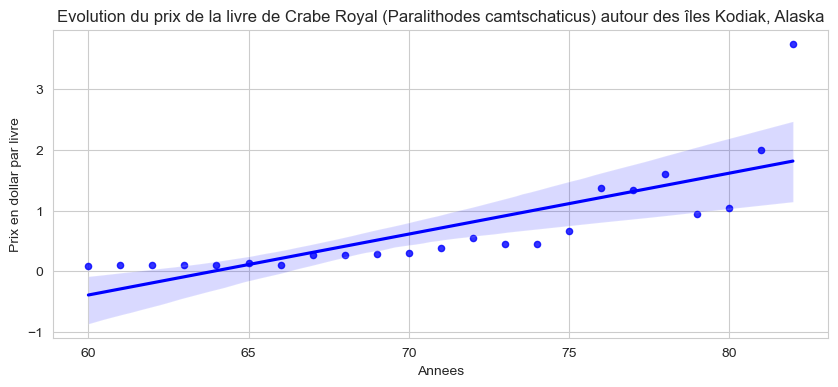

In [31]:
# Figure 2 : Prix en fonction des années, Plot + intervalle de confiance à 95 %
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Price_crab', color='#0000FF', scatter_kws={'s':20})
plt.title("Evolution du prix de la livre de Crabe Royal (Paralithodes camtschaticus) autour des îles Kodiak, Alaska")
plt.xlabel("Annees")
plt.ylabel("Prix en dollar par livre")
plt.show()

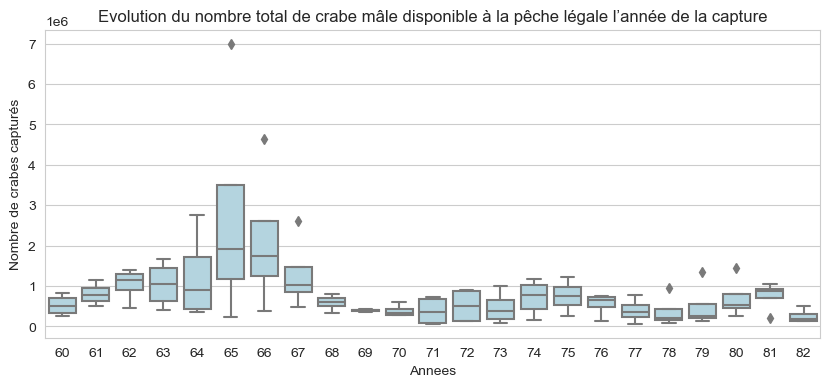

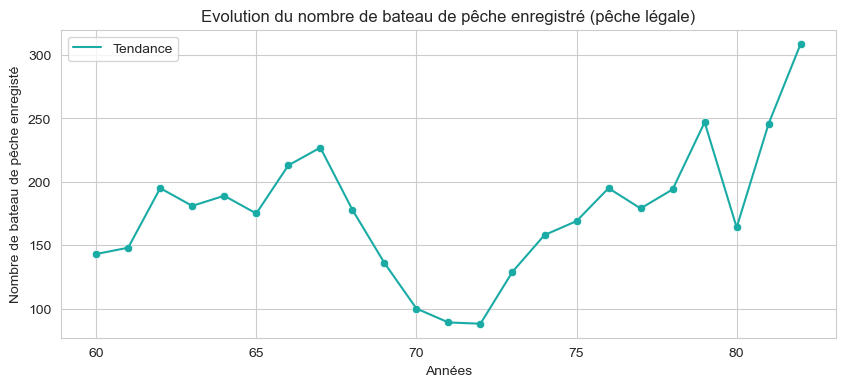

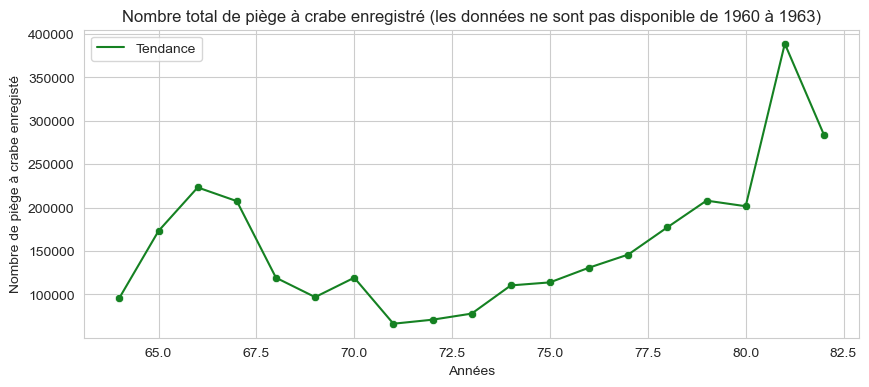

In [32]:
sns.set_style("whitegrid")

# Figure 3: Nombre de capture en fonction du temps
plt.figure(figsize=(10, 4))
sns.boxplot(data=catch, x='annee', y='Nbcapture', color='lightblue')
plt.title("Evolution du nombre total de crabe mâle disponible à la pêche légale l’année de la capture")
plt.xlabel("Annees")
plt.ylabel("Nombre de crabes capturés")
plt.show()

# Figure 4: Nombre de bateaux de pêche
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='Vessels_register_fishing', color="#1AABA5", label="Tendance")
sns.scatterplot(data=fleet, x='Year', y='Vessels_register_fishing', color="#1AABA5")
plt.title("Evolution du nombre de bateau de pêche enregistré (pêche légale)")
plt.xlabel("Années")
plt.ylabel("Nombre de bateau de pêche enregisté")
plt.show()

# Figure 5: Nombre de piège
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='pot_lifts', color="#158122", label="Tendance")
sns.scatterplot(data=fleet, x='Year', y='pot_lifts', color="#158122")
plt.title("Nombre total de piège à crabe enregistré (les données ne sont pas disponible de 1960 à 1963)")
plt.xlabel("Années")
plt.ylabel("Nombre de piège à crabe enregisté")
plt.show()


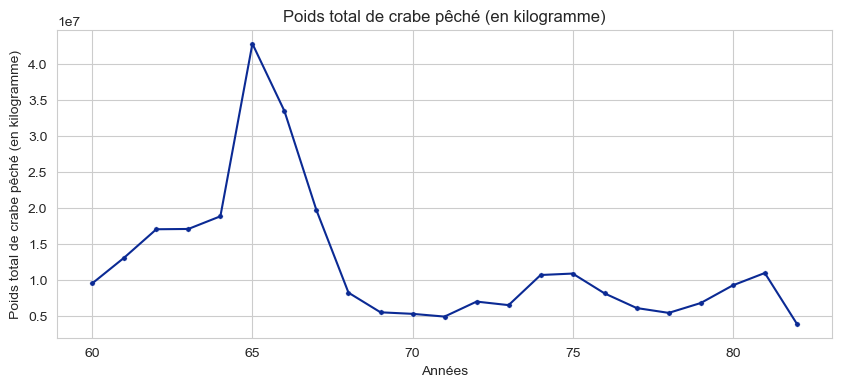

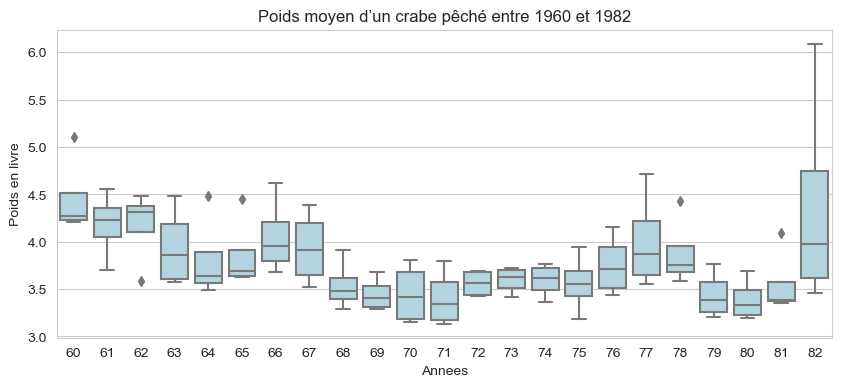

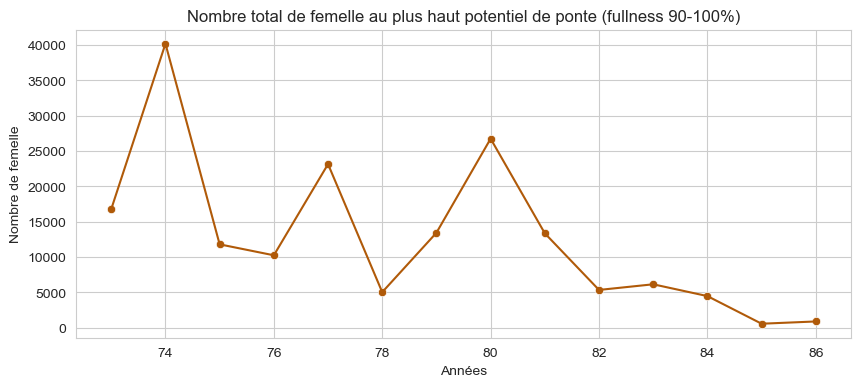

In [33]:
# Figure 6: Poids total des captures
plt.figure(figsize=(10, 4))
sns.lineplot(data=fleet, x='Year', y='Weight_crab_catch', color="#0B2A94")
sns.scatterplot(data=fleet, x='Year', y='Weight_crab_catch', color="#0B2A94", s=15)
plt.title("Poids total de crabe pêché (en kilogramme)")
plt.xlabel("Années")
plt.ylabel("Poids total de crabe pêché (en kilogramme)")
plt.show()

# Figure 7: Poids moyen des crabes
plt.figure(figsize=(10, 4))
sns.boxplot(data=catch, x='annee', y='PoidsCrabs', color='lightblue')
plt.title("Poids moyen d’un crabe pêché entre 1960 et 1982")
plt.xlabel("Annees")
plt.ylabel("Poids en livre")
plt.show()

# Figure 8: Fullness femelles 100%
fullness_years = fullness.groupby('Year').agg({'90-100%_fullness':'sum'}).reset_index()
plt.figure(figsize=(10, 4))
sns.lineplot(data = fullness_years, x = "Year", y ='90-100%_fullness', color="#B05A09")
sns.scatterplot(data=fullness_years, x='Year', y='90-100%_fullness', color="#B05A09")
plt.title("Nombre total de femelle au plus haut potentiel de ponte (fullness 90-100%)")
plt.xlabel("Années")
plt.ylabel("Nombre de femelle")
plt.show()

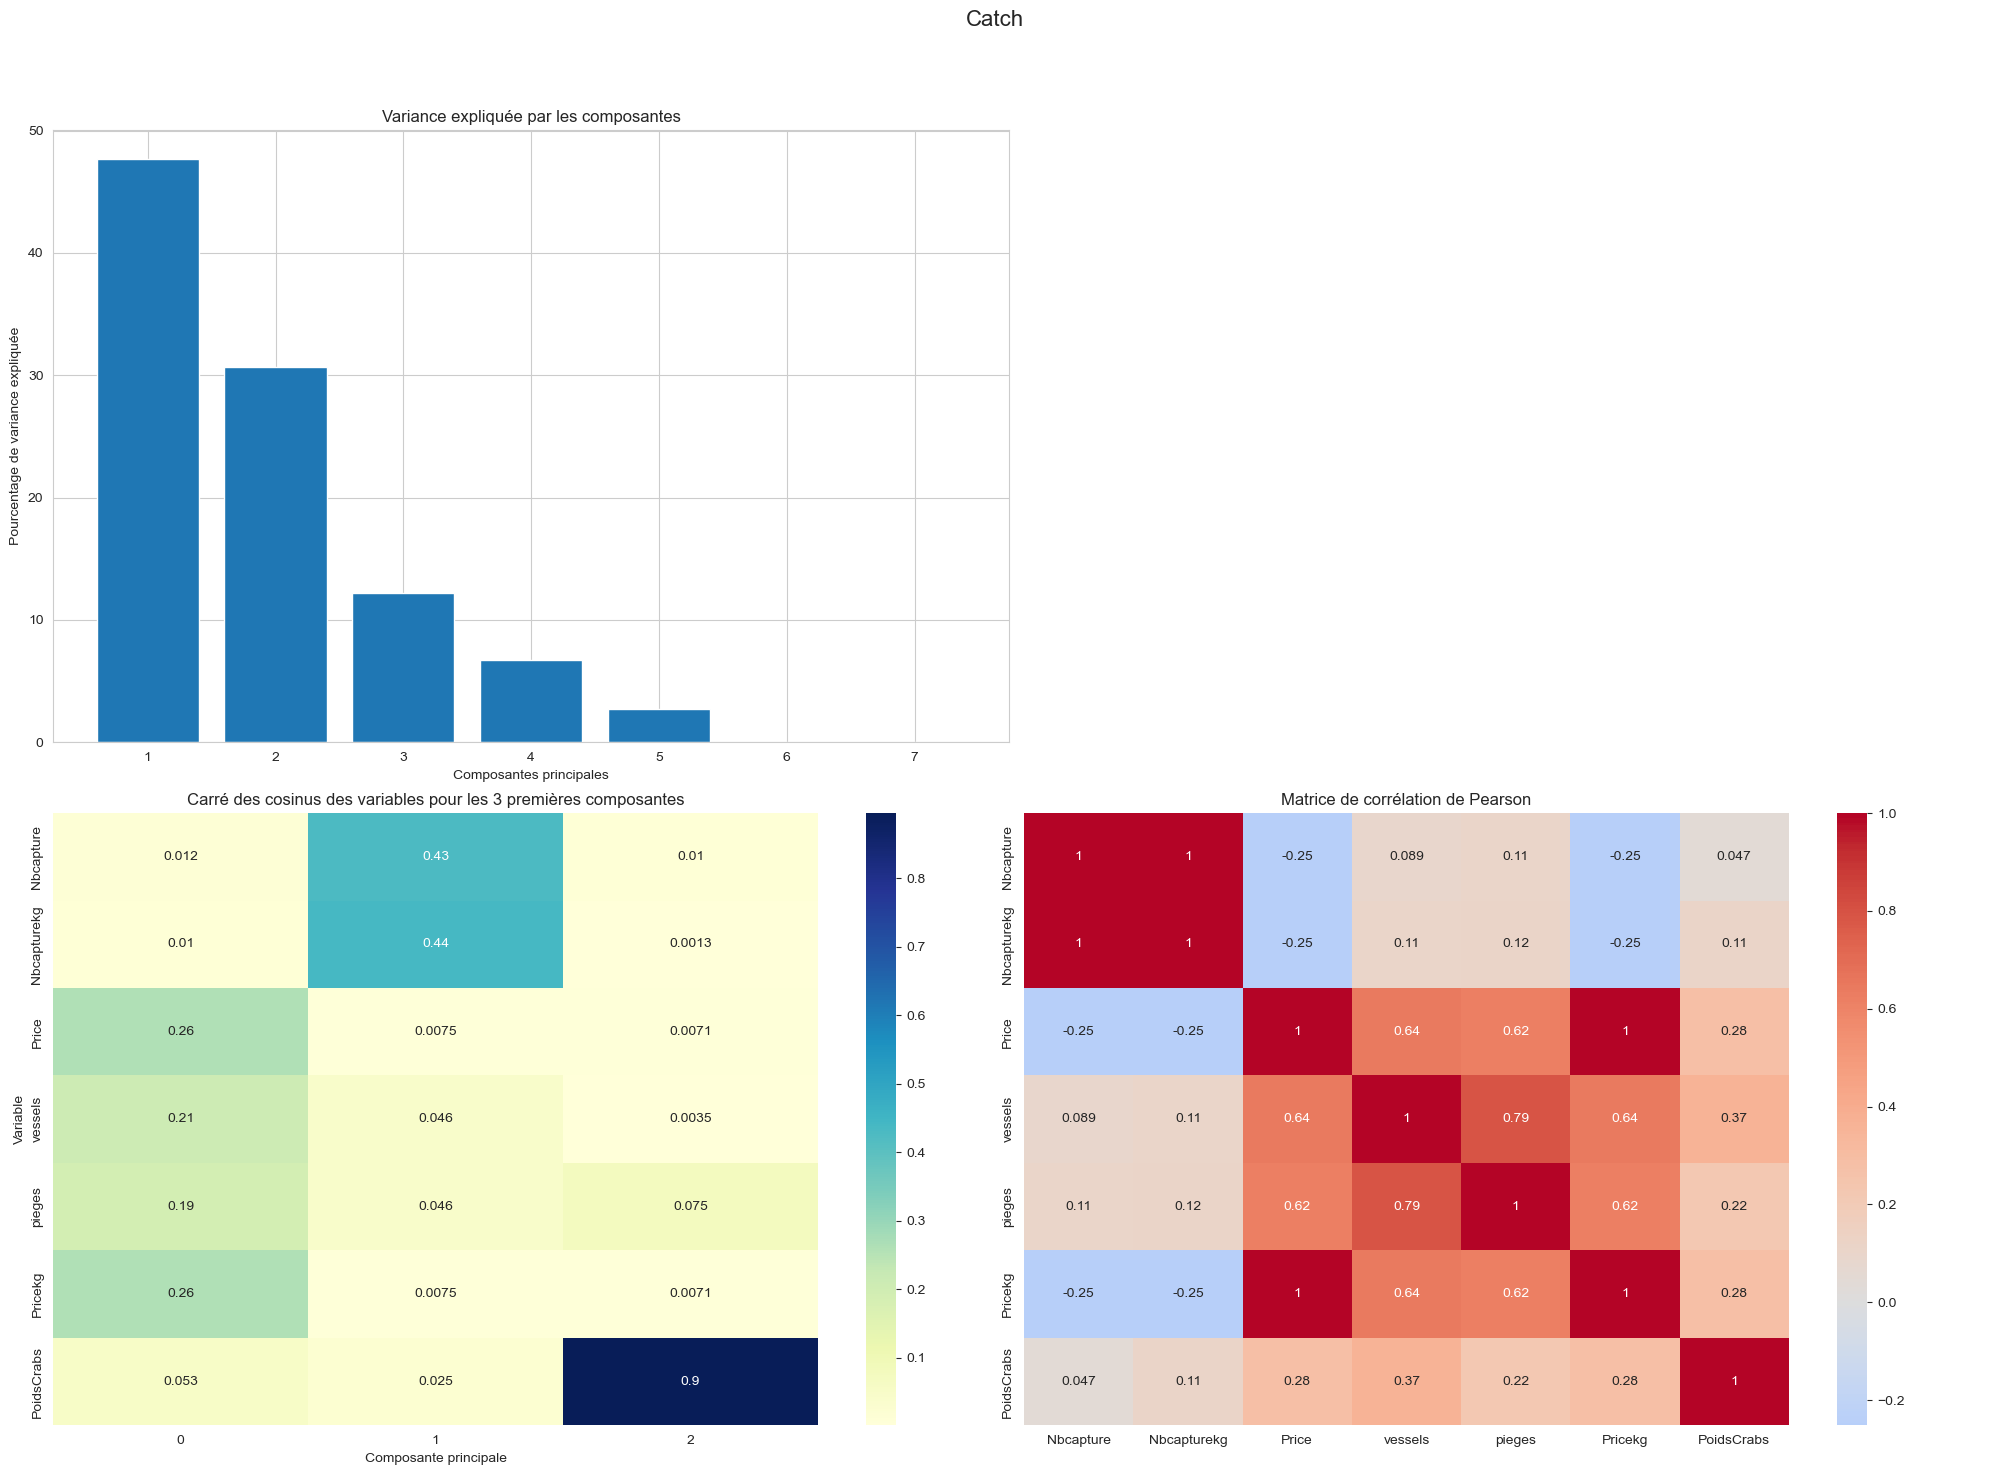

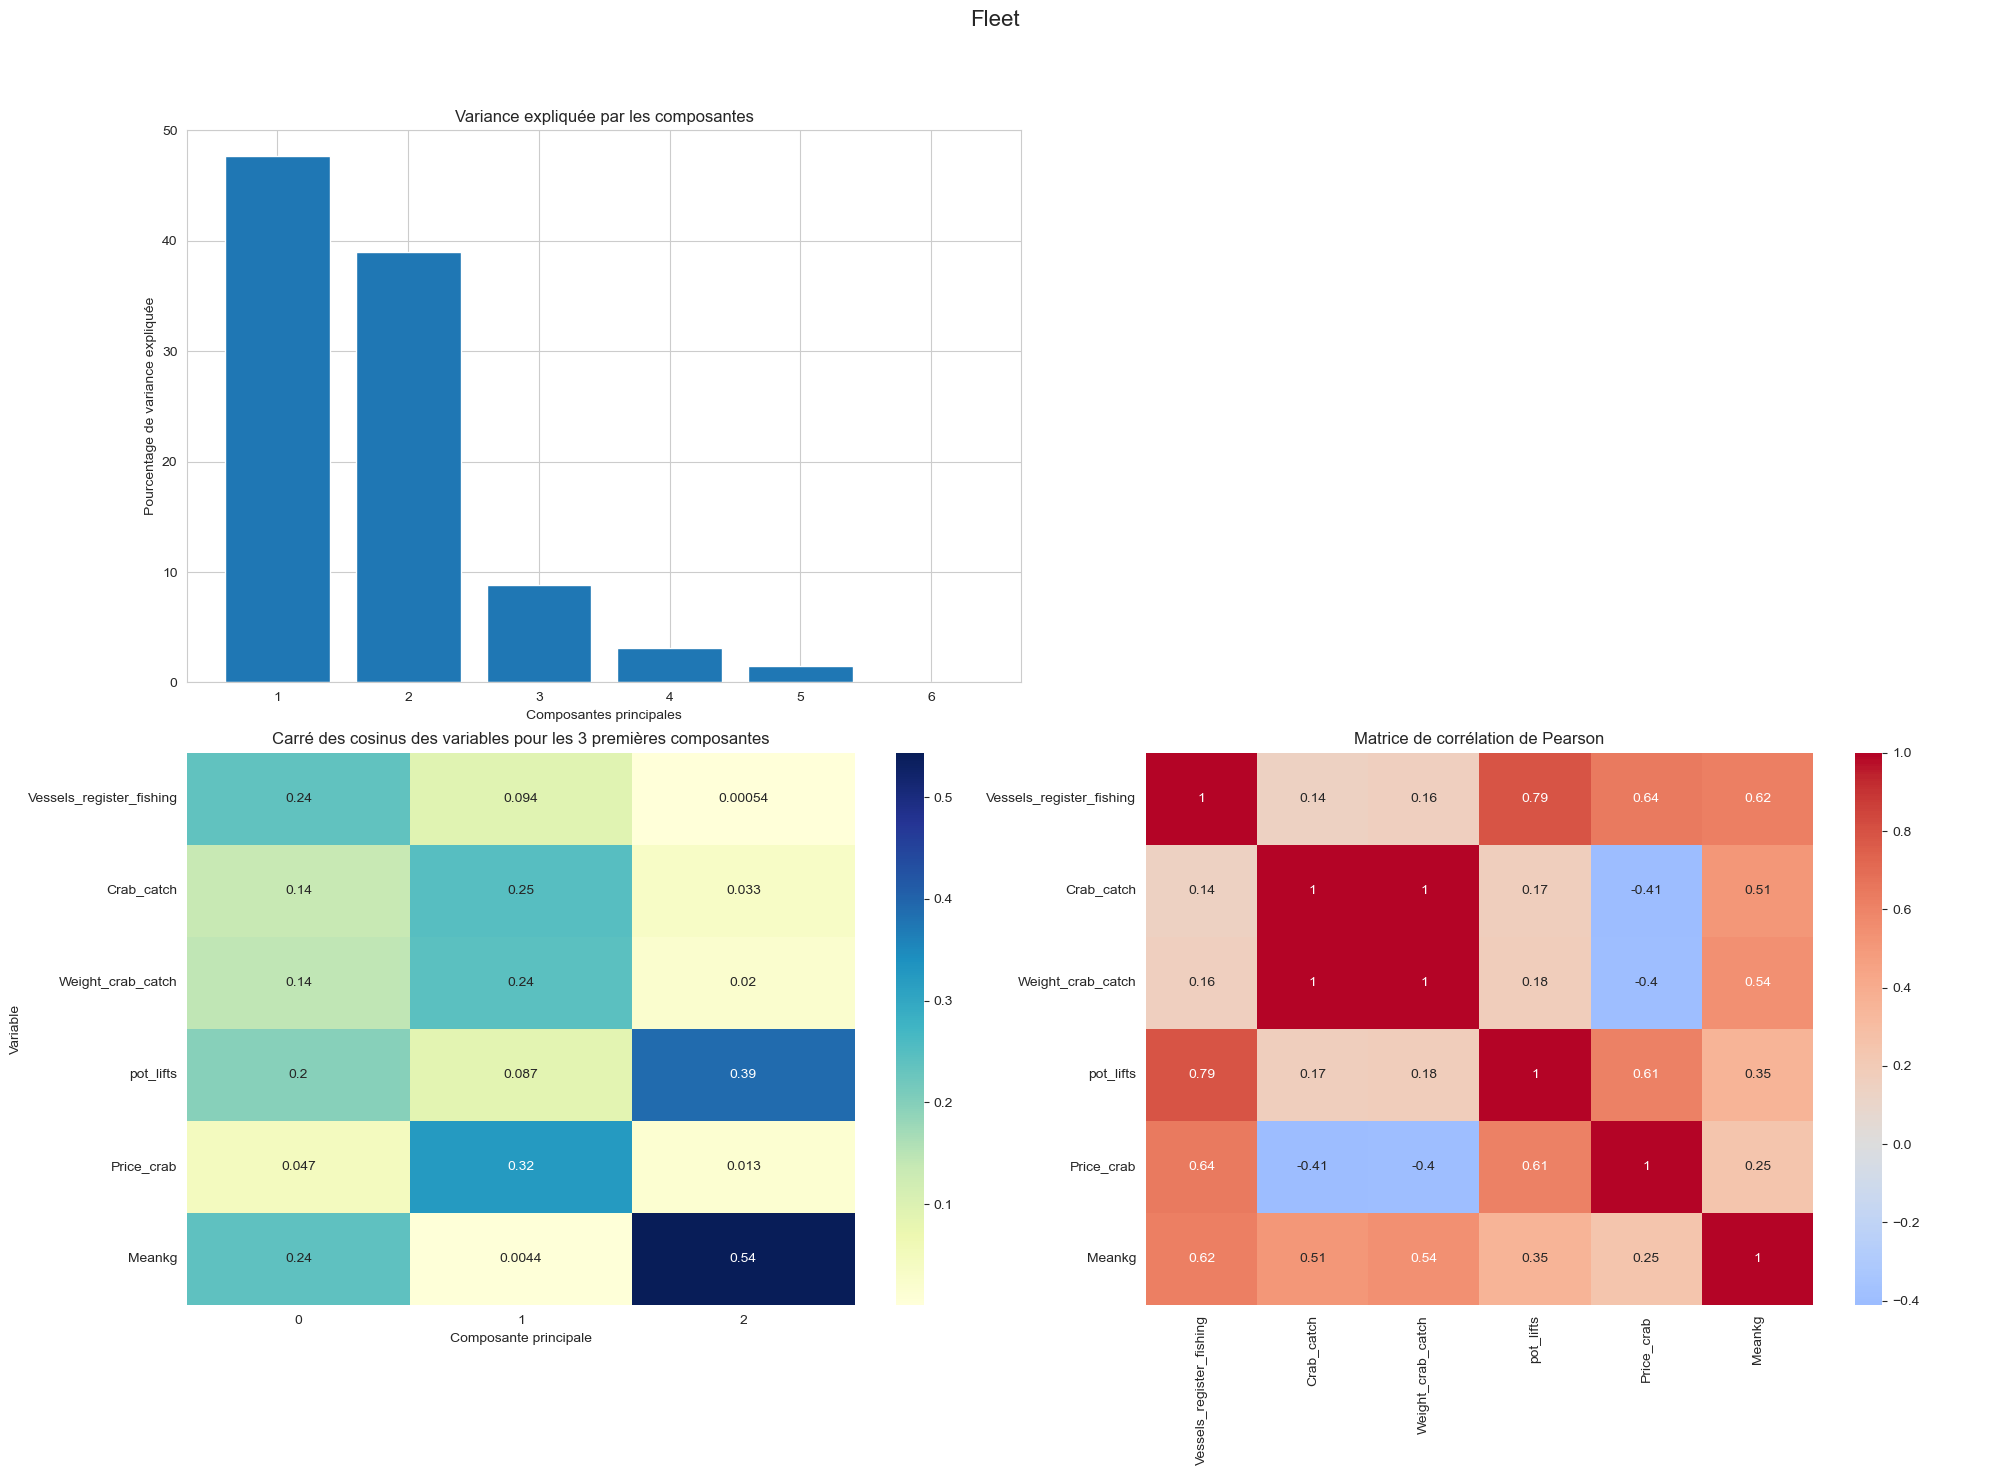

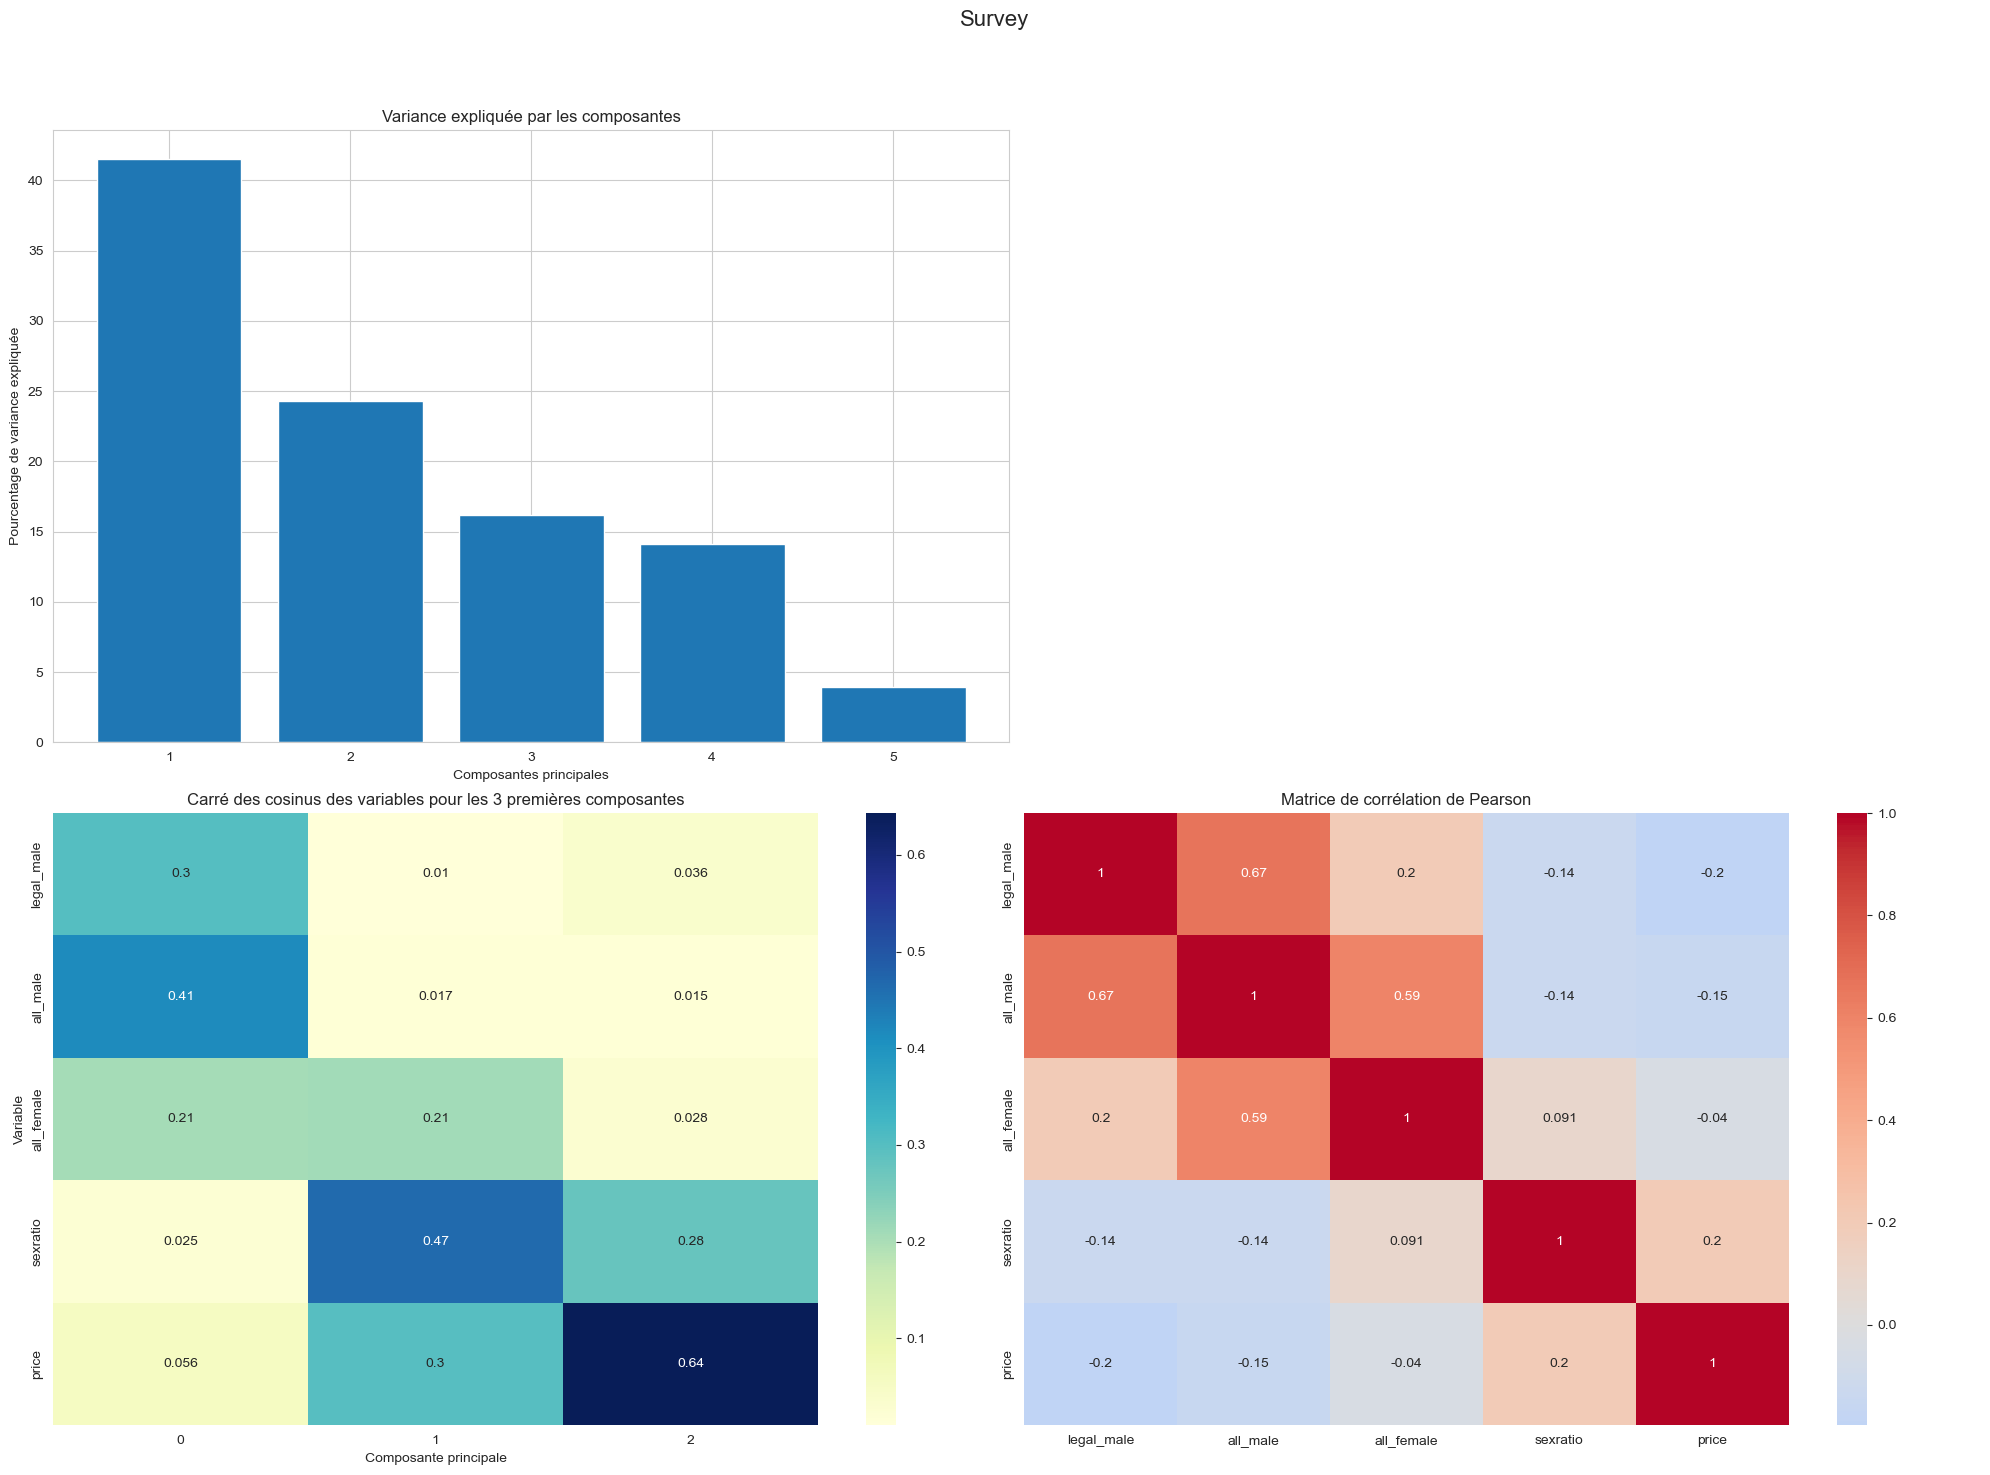

In [34]:
def perform_PCA(data, title) :
    # Verification valeurs inf
    data = data.copy() # Evite un message d'avertissement de pandas
    data.replace([np.inf, -np.inf], np.nan, inplace = True)
    # Suppression des Nan
    data = data.dropna()
    data_scale = StandardScaler().fit_transform(data)
    pca_model = PCA()
    pca = pca_model.fit_transform(data_scale)

    #Valeurs propres
    eigenvalues = pca_model.explained_variance_ratio_ * 100

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(title, fontsize=16)

    axs[0, 0].bar(range(1, len(eigenvalues) + 1), eigenvalues)
    axs[0, 0].set_xlabel('Composantes principales')
    axs[0, 0].set_ylabel('Pourcentage de variance expliquée')
    axs[0, 0].set_title('Variance expliquée par les composantes')
    axs[0, 1].axis('off')

    cos2_vars = (pca_model.components_**2).T

    # Heatmap cos2
    sns.heatmap(cos2_vars[:, :3], annot=True, cmap="YlGnBu", yticklabels=data.columns, ax=axs[1, 0])
    axs[1, 0].set_xlabel('Composante principale')
    axs[1, 0].set_ylabel('Variable')
    axs[1, 0].set_title('Carré des cosinus des variables pour les 3 premières composantes')

    correlation_df = pd.DataFrame(data_scale)
    correlation_matrix = correlation_df.corr(method='pearson')

    # Heatmap Pearson
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, xticklabels=data.columns, yticklabels=data.columns, ax=axs[1, 1])
    axs[1, 1].set_title("Matrice de corrélation de Pearson")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

perform_PCA(catch.iloc[:, 2:9], "Catch")
perform_PCA(fleet.iloc[:, 1:7], "Fleet")
survey_pca = survey[['legal_male','all_male','all_female','sexratio','price']]
perform_PCA(survey_pca, "Survey")


In [35]:
def plot_diagnostiques(mod):
  # Plot diagnostiques
  # Résidus vs Valeurs Prédites
  fig, axes = plt.subplots(2, 2, figsize=(14, 10))
  axes[0, 0].scatter(mod.fittedvalues, mod.resid_pearson, alpha=0.5)
  axes[0, 0].axhline(0, color='red')
  axes[0, 0].set_xlabel('Valeurs prédites')
  axes[0, 0].set_ylabel('Résidus standardisés')
  axes[0, 0].set_title('Résidus vs. Valeurs Prédites')

  # Histogramme des résidus
  axes[0, 1].hist(mod.resid_pearson, bins=50, edgecolor='k', alpha=0.7)
  axes[0, 1].set_xlabel('Résidus standardisés')
  axes[0, 1].set_title('Histogramme des Résidus')

  # Q-Q Plot des résidus
  qqplot(mod.resid_pearson, line='45', fit=True, ax=axes[1, 0])
  axes[1, 0].set_title('Q-Q Plot des résidus')

  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()

                            OLS Regression Results                            
Dep. Variable:         Meanprice1crab   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     94.29
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           7.59e-16
Time:                        15:51:51   Log-Likelihood:                -301.54
No. Observations:                  96   AIC:                             607.1
Df Residuals:                      94   BIC:                             612.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.1647      6.322     -8.726      0.0

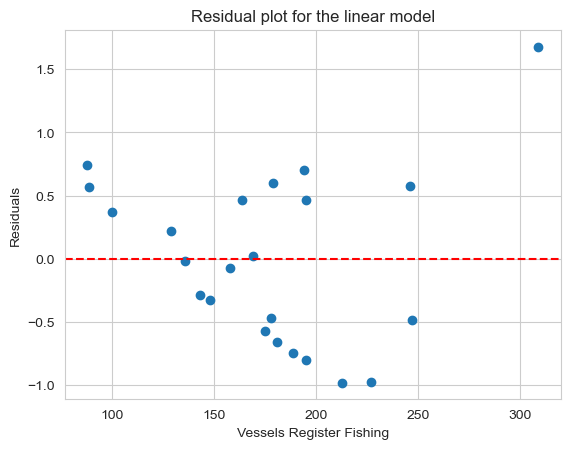

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     14.16
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           4.38e-05
Time:                        15:51:51   Log-Likelihood:                -21.525
No. Observations:                  23   AIC:                             51.05
Df Residuals:                      19   BIC:                             55.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

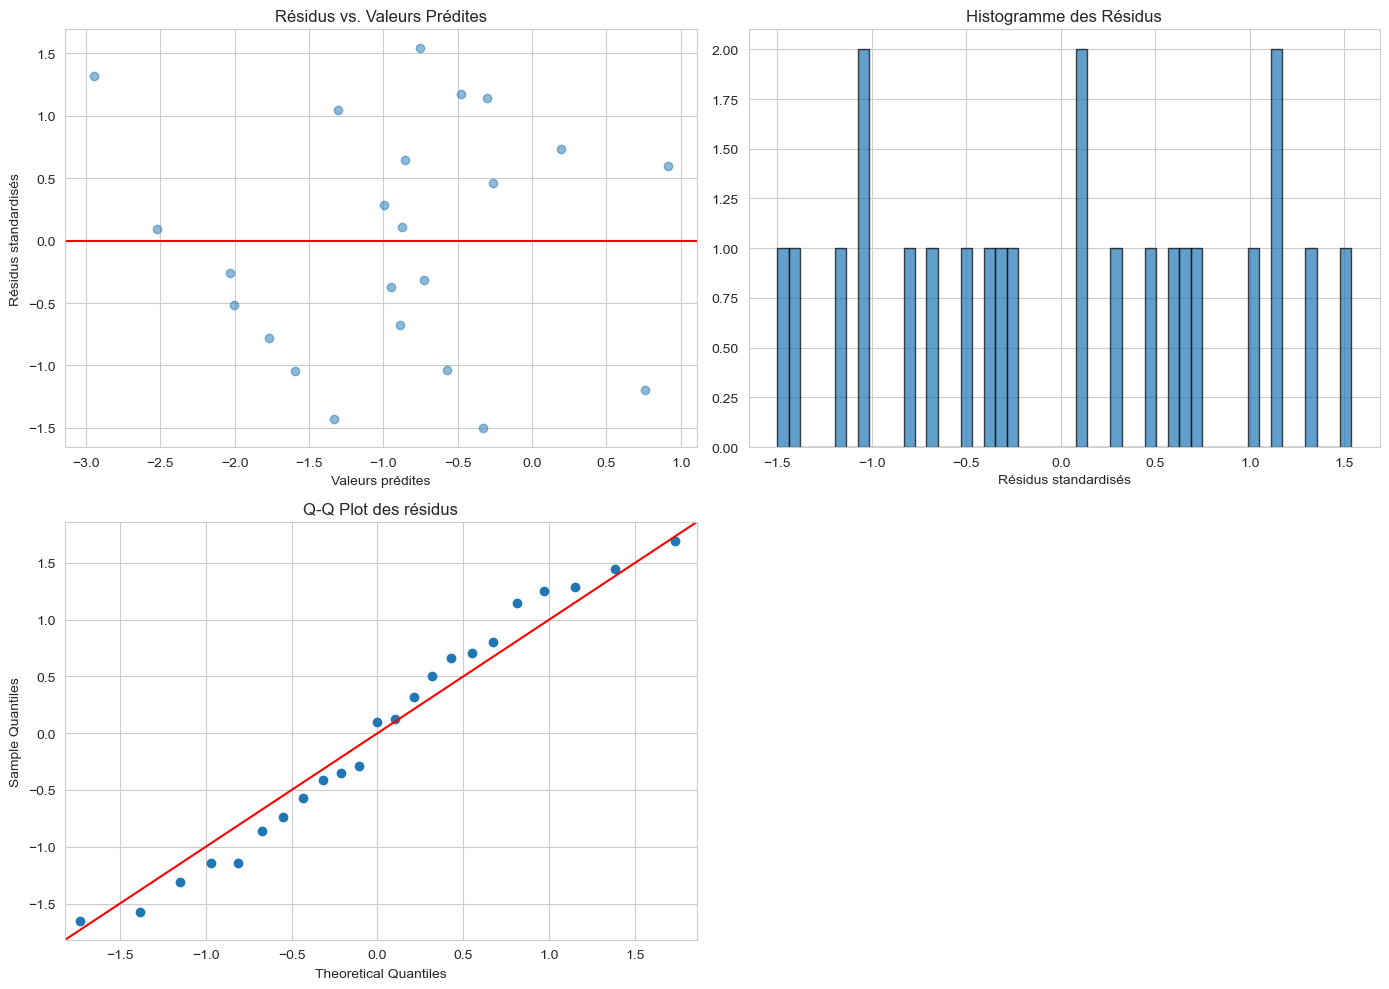

In [36]:
#### Evolution et modélisation du prix du Crabe Royal entre 1960 et 1982 :
### Prix moyen ~ Année
X = sm.add_constant(catch['annee'])
y = catch['Meanprice1crab']
mod_prix1crab1 = sm.OLS(y, X).fit()
print(mod_prix1crab1.summary())
# AIC: 607.1 annee 0.8594 P>|t| 0.000

### Prix ~ Nbr bateaux
X = sm.add_constant(fleet['Vessels_register_fishing'])
y = fleet['Price_crab']
modprix = sm.OLS(y, X).fit()
print(modprix.summary())

# Plot des résidus
plt.scatter(fleet['Vessels_register_fishing'], modprix.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vessels Register Fishing')
plt.ylabel('Residuals')
plt.title('Residual plot for the linear model')
plt.show()
# Heteroscedasticité

### log(Prix) ~ Nbr bateaux + capture + poids moyen (kg)
X = sm.add_constant(fleet[['Vessels_register_fishing', 'Crab_catch', 'Meankg']])
y = fleet['logprice']
modprixlog = sm.OLS(y, X).fit()
print(modprixlog.summary())

plot_diagnostiques(modprixlog)

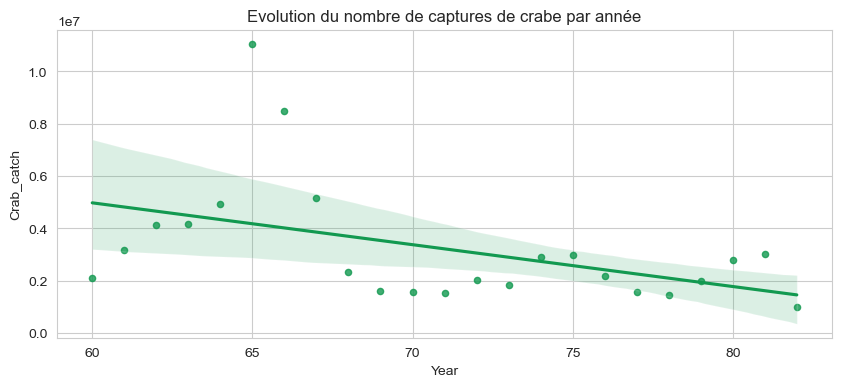

1048542.4936920922
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Crab_catch   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -366.31
Date:                Wed, 01 Nov 2023   Deviance:                       5.7685
Time:                        15:51:52   Pearson chi2:                     6.95
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1110
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6625      2.242 

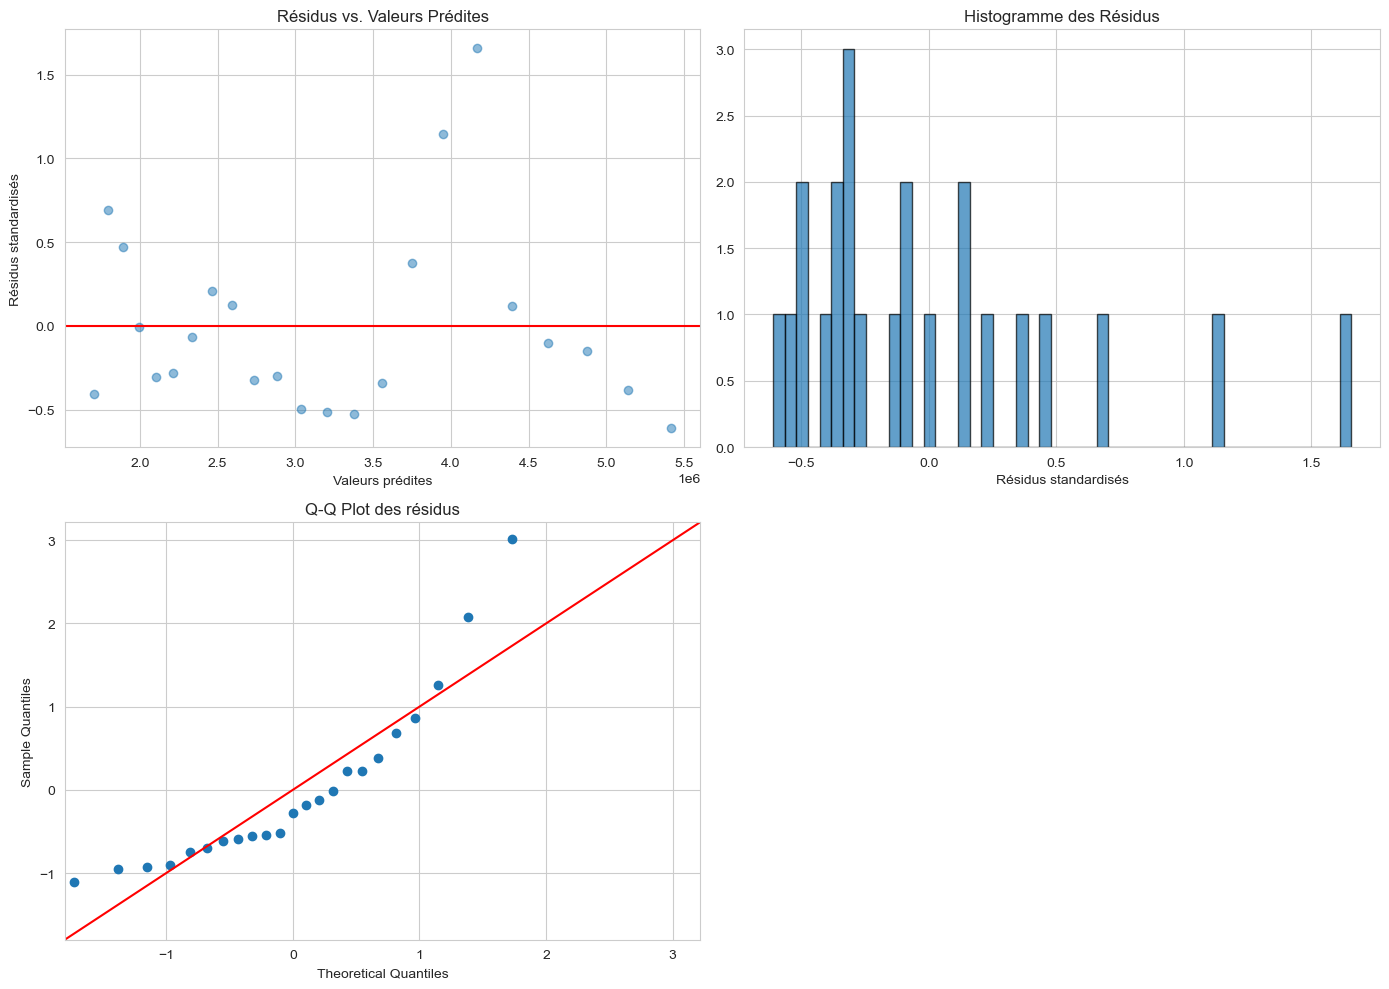

In [37]:
#### Evolution de la pêche autour des îles Kodiak :
## Modelisation nombre de capture
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Crab_catch', color='#129950', scatter_kws={'s':20})
plt.xlabel("Year")
plt.ylabel("Crab_catch")
plt.title("Evolution du nombre de captures de crabe par année")
plt.show()
# Tendance à la baisse

X = sm.add_constant(fleet['Year'])
Y = fleet['Crab_catch']
mod_crabcatch = sm.GLM(Y,X, family = sm.families.Poisson()).fit()
# Calcul de la dispersion
dispersion = mod_crabcatch.deviance / mod_crabcatch.df_resid
# Dispersion élevée
print(dispersion)

# Modele binomial negatif
mod_crabcatch_nb = sm.GLM(Y, X, family=sm.families.NegativeBinomial()).fit()
print(mod_crabcatch_nb.summary())

plot_diagnostiques(mod_crabcatch_nb)

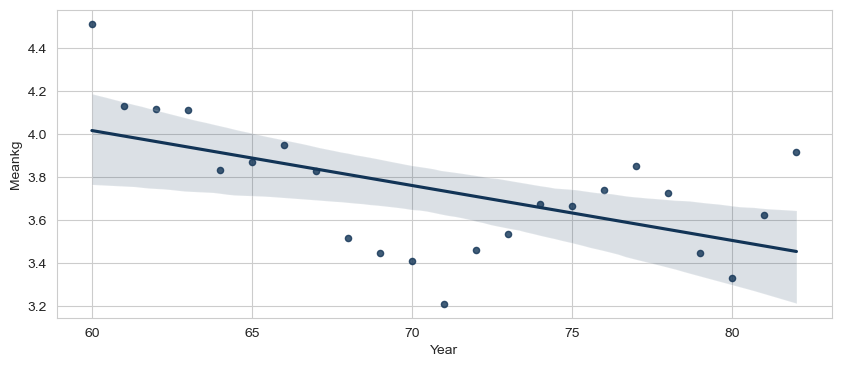

                            OLS Regression Results                            
Dep. Variable:                 Meankg   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     9.839
Date:                Wed, 01 Nov 2023   Prob (F-statistic):            0.00498
Time:                        15:51:52   Log-Likelihood:               -0.59464
No. Observations:                  23   AIC:                             5.189
Df Residuals:                      21   BIC:                             7.460
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5542      0.583      9.535      0.0

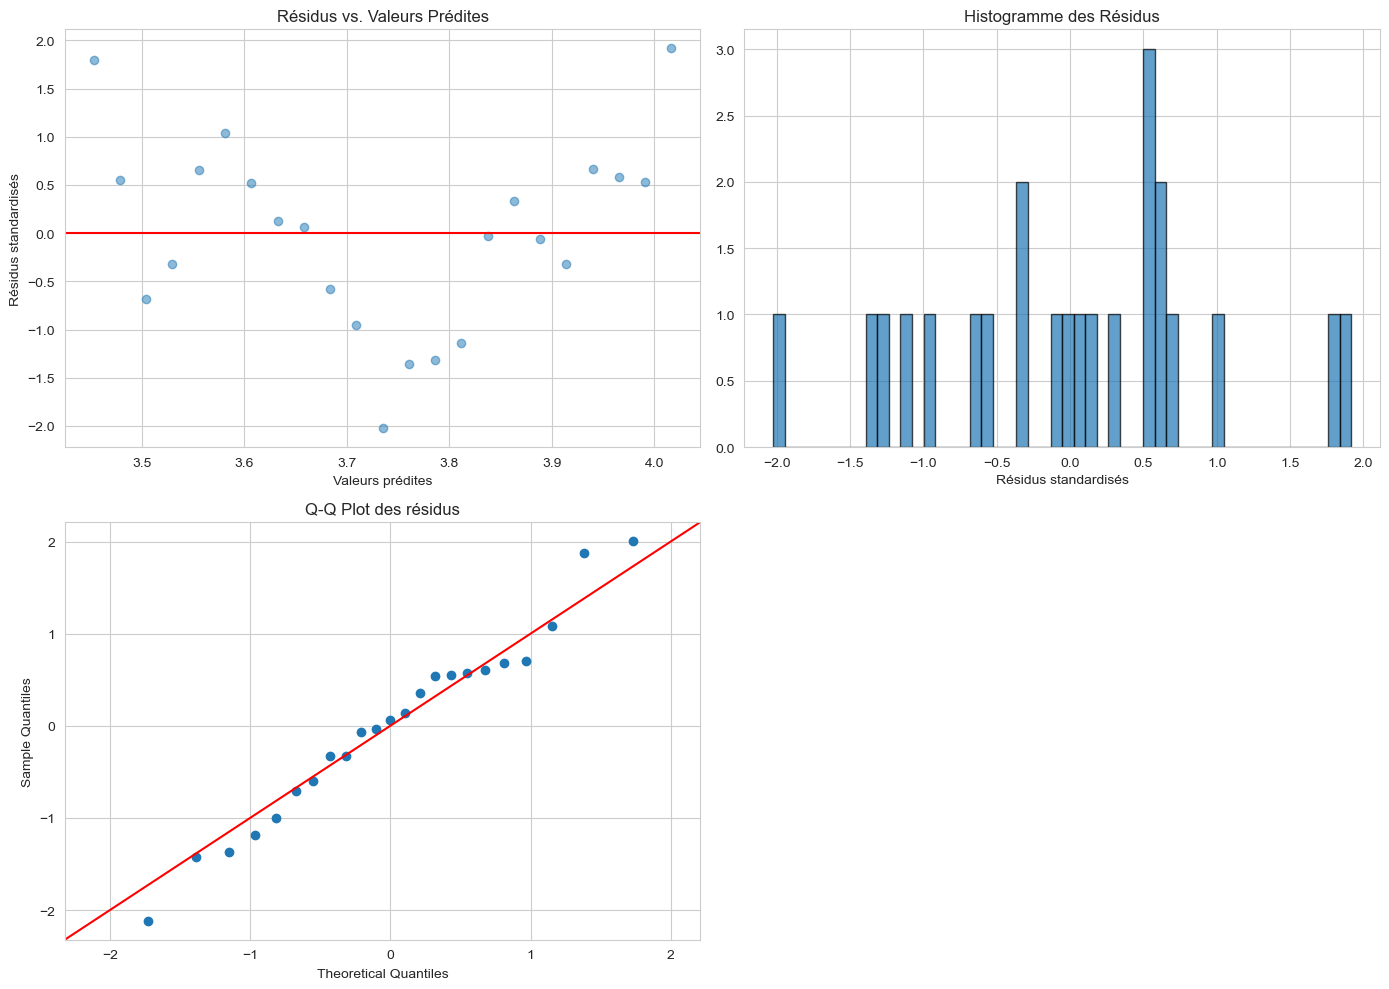

In [38]:
# Modelisation poids moyen
plt.figure(figsize=(10, 4))
sns.regplot(data=fleet, x='Year', y='Meankg', color='#123456', scatter_kws={'s':20})
plt.xlabel('Year')
plt.ylabel('Meankg')
plt.show()
# Tendance à la baisse

X = sm.add_constant(fleet["Year"])
Y = fleet['Meankg']
mod_poidsmoyen = sm.OLS(Y,X).fit()
print(mod_poidsmoyen.summary())

plot_diagnostiques(mod_poidsmoyen)

C:\Users\Windows\AppData\Local\Temp\ipykernel_21060\3091695232.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_no73['district'] = survey_no73['district'].astype('category')
C:\Users\Windows\AppData\Local\Temp\ipykernel_21060\3091695232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_no73['annee'] = survey_no73['annee'].astype('category')


annee             0
district          0
station           0
pots              0
latitude          0
longitude         0
pre4              0
pre3              0
pre2              0
pre1              0
rmale             0
prmale            0
juvfemale         0
adultfemale       0
price          1179
legal_male        0
all_male          0
all_female        0
sexratio       1629
dtype: int64
annee            0
district         0
station          0
pots             0
latitude         0
longitude        0
pre4             0
pre3             0
pre2             0
pre1             0
rmale            0
prmale           0
juvfemale        0
adultfemale      0
price            0
legal_male       0
all_male         0
all_female       0
sexratio       149
dtype: int64


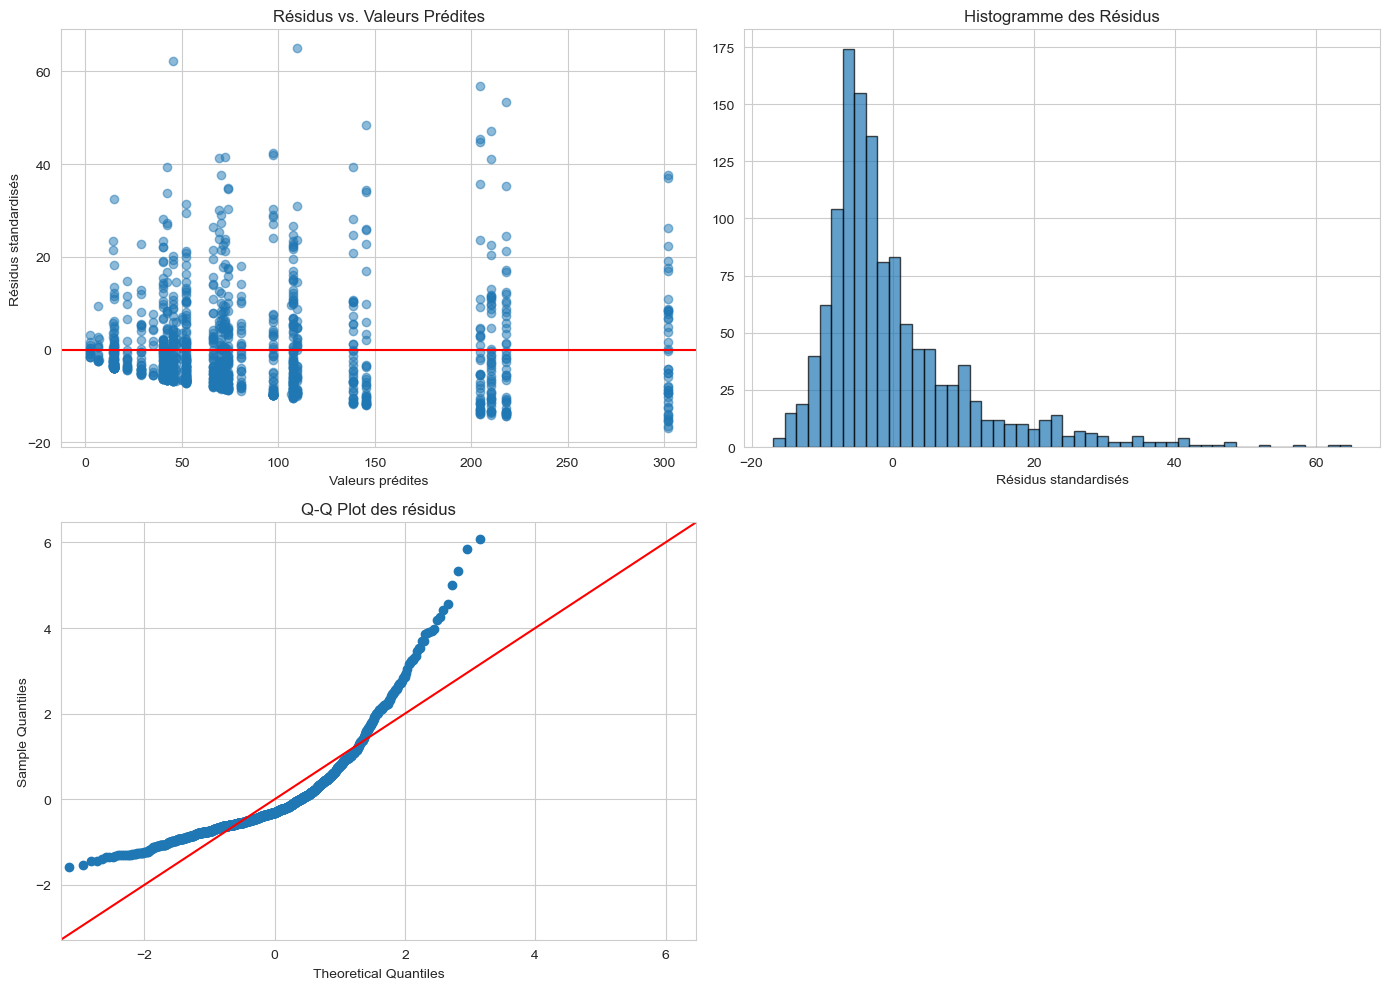

                 Generalized Linear Model Regression Results                  
Dep. Variable:             legal_male   No. Observations:                 1252
Model:                            GLM   Df Residuals:                     1218
Model Family:                 Poisson   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62938.
Date:                Wed, 01 Nov 2023   Deviance:                   1.1950e+05
Time:                        15:51:53   Pearson chi2:                 1.42e+05
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [39]:
#### Evolution de l’abondance en crabes MALES disponible à la pêche:
# Suppression de l'année 1973 car l'abondance est deja anormalement basse, donc on ne veut pas la prendre comme reference dans notre model
survey_no73 = survey[survey['annee'] != 73]
survey_no73['district'] = survey_no73['district'].astype('category')
survey_no73['annee'] = survey_no73['annee'].astype('category')


print(survey_no73.isnull().sum())  # Pour voir le nombre de NaN par colonne
print((survey_no73 == float('inf')).sum())  # Pour voir le nombre d'infinis par colonne
survey_no73 = survey_no73.dropna()
survey_no73 = survey_no73.replace([float('inf'), -float('inf')], np.nan).dropna()

formula = 'legal_male ~ annee + district + annee:district'
mod_legal_male = smf.glm(formula = formula, data = survey_no73,family=sm.families.Poisson()).fit()
plot_diagnostiques(mod_legal_male)
print(mod_legal_male.summary())


                            OLS Regression Results                            
Dep. Variable:              legalmale   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     9.985
Date:                Wed, 01 Nov 2023   Prob (F-statistic):             0.0123
Time:                        15:51:53   Log-Likelihood:                -101.27
No. Observations:                  11   AIC:                             214.5
Df Residuals:                       5   BIC:                             216.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e+05   4.47e+05      1.958      0.1

c:\Users\Windows\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


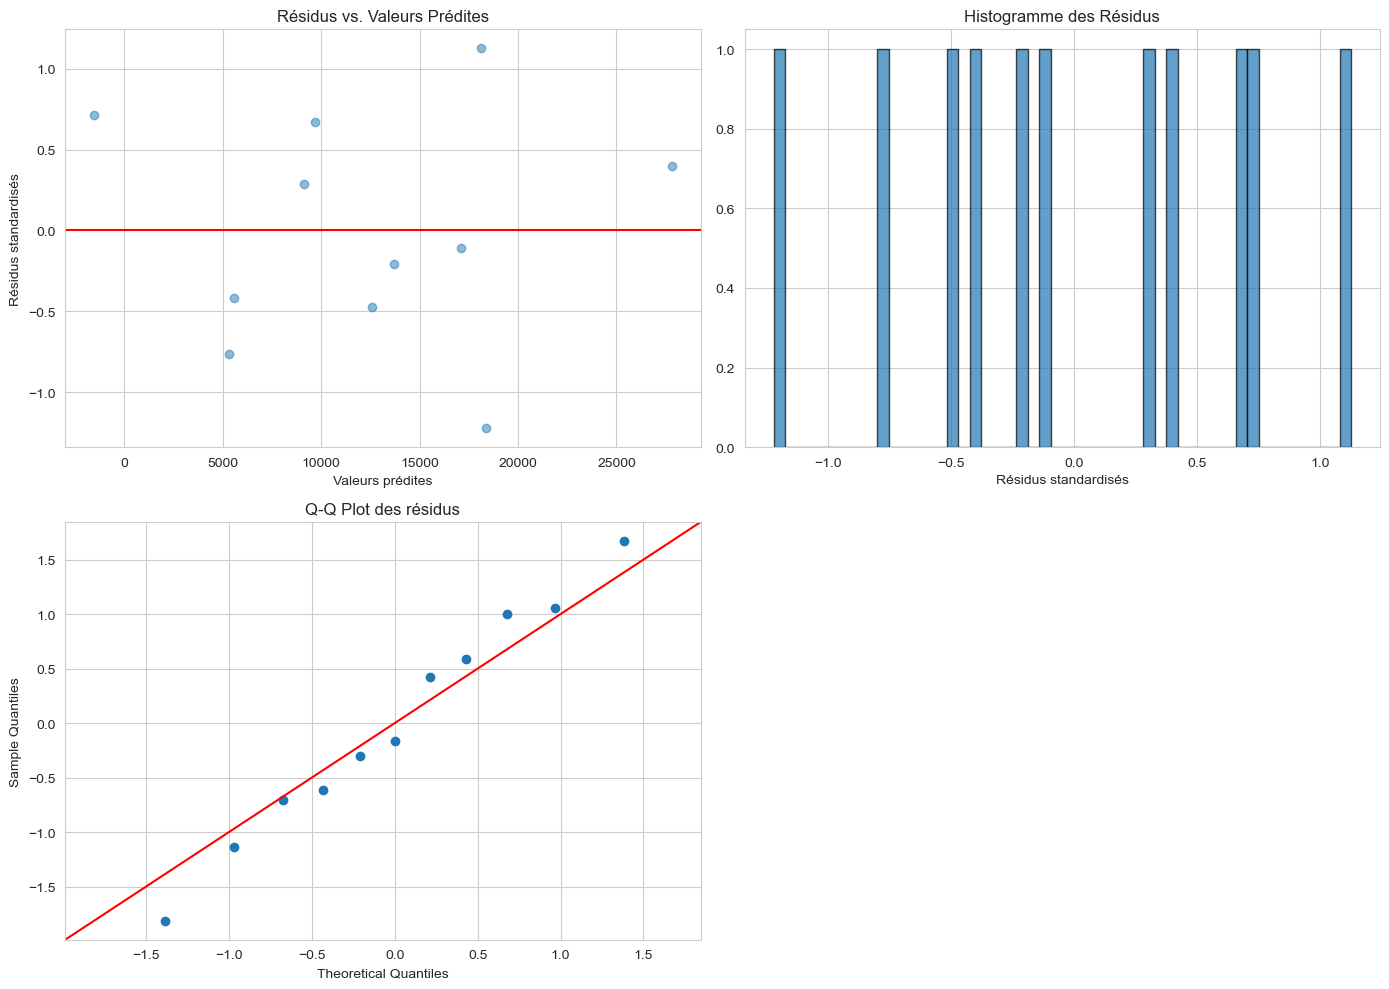

['Year', 'salinity', 'temp', 'meansex', 'full', 'f29']


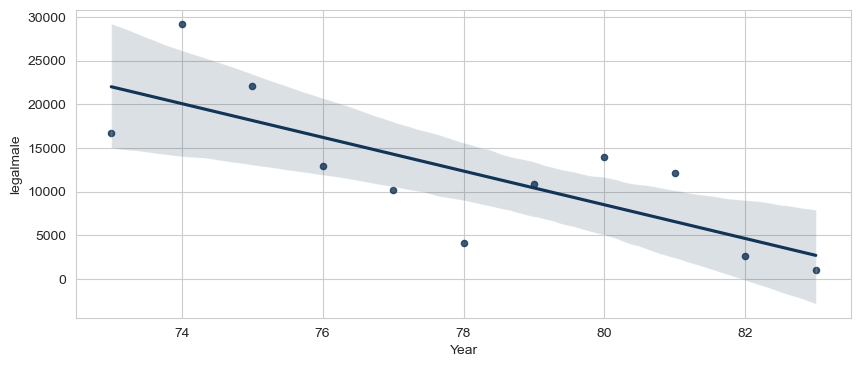

Year-0.7646867643492756


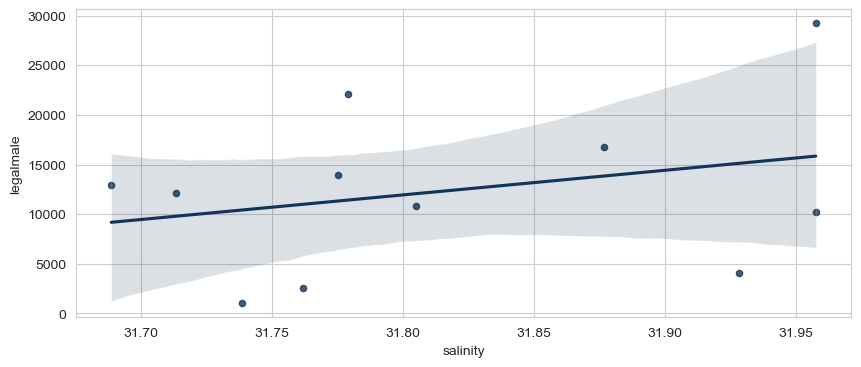

salinity0.2887051431317118


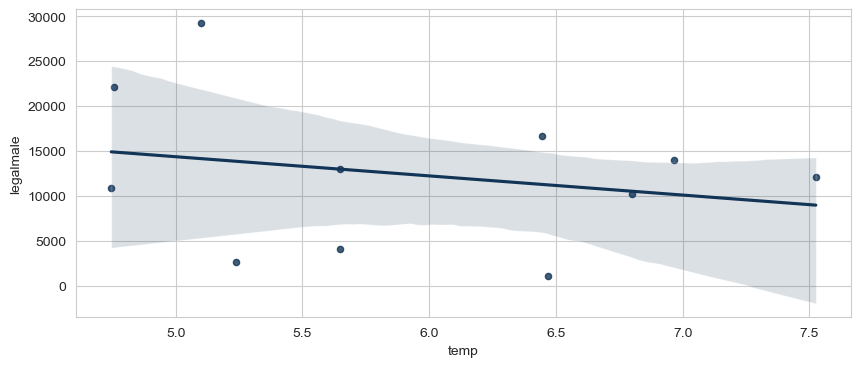

temp-0.24236574078508727


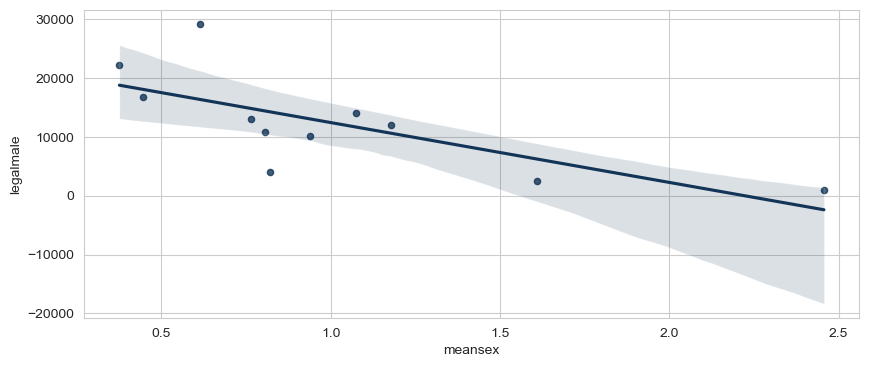

meansex-0.7192472783515695


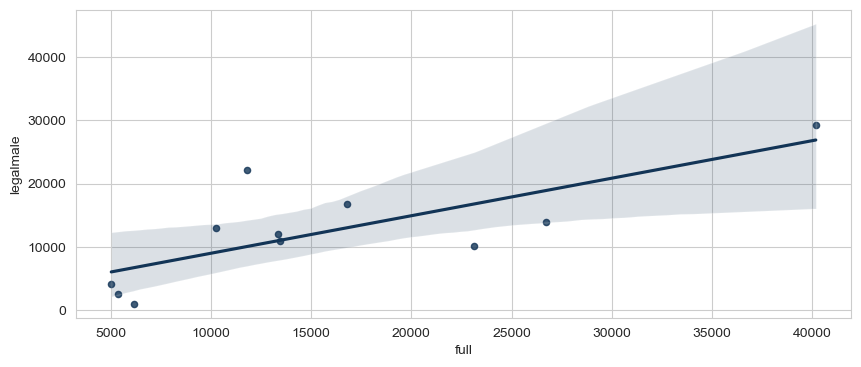

full0.7579550949969942


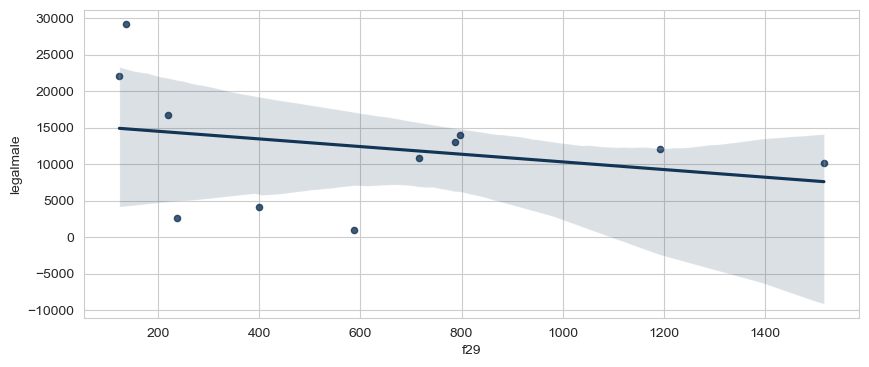

f29-0.28238078851965603
                            OLS Regression Results                            
Dep. Variable:              legalmale   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     7.295
Date:                Wed, 01 Nov 2023   Prob (F-statistic):             0.0653
Time:                        15:51:54   Log-Likelihood:                -98.546
No. Observations:                  11   AIC:                             213.1
Df Residuals:                       3   BIC:                             216.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.433e+

c:\Users\Windows\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


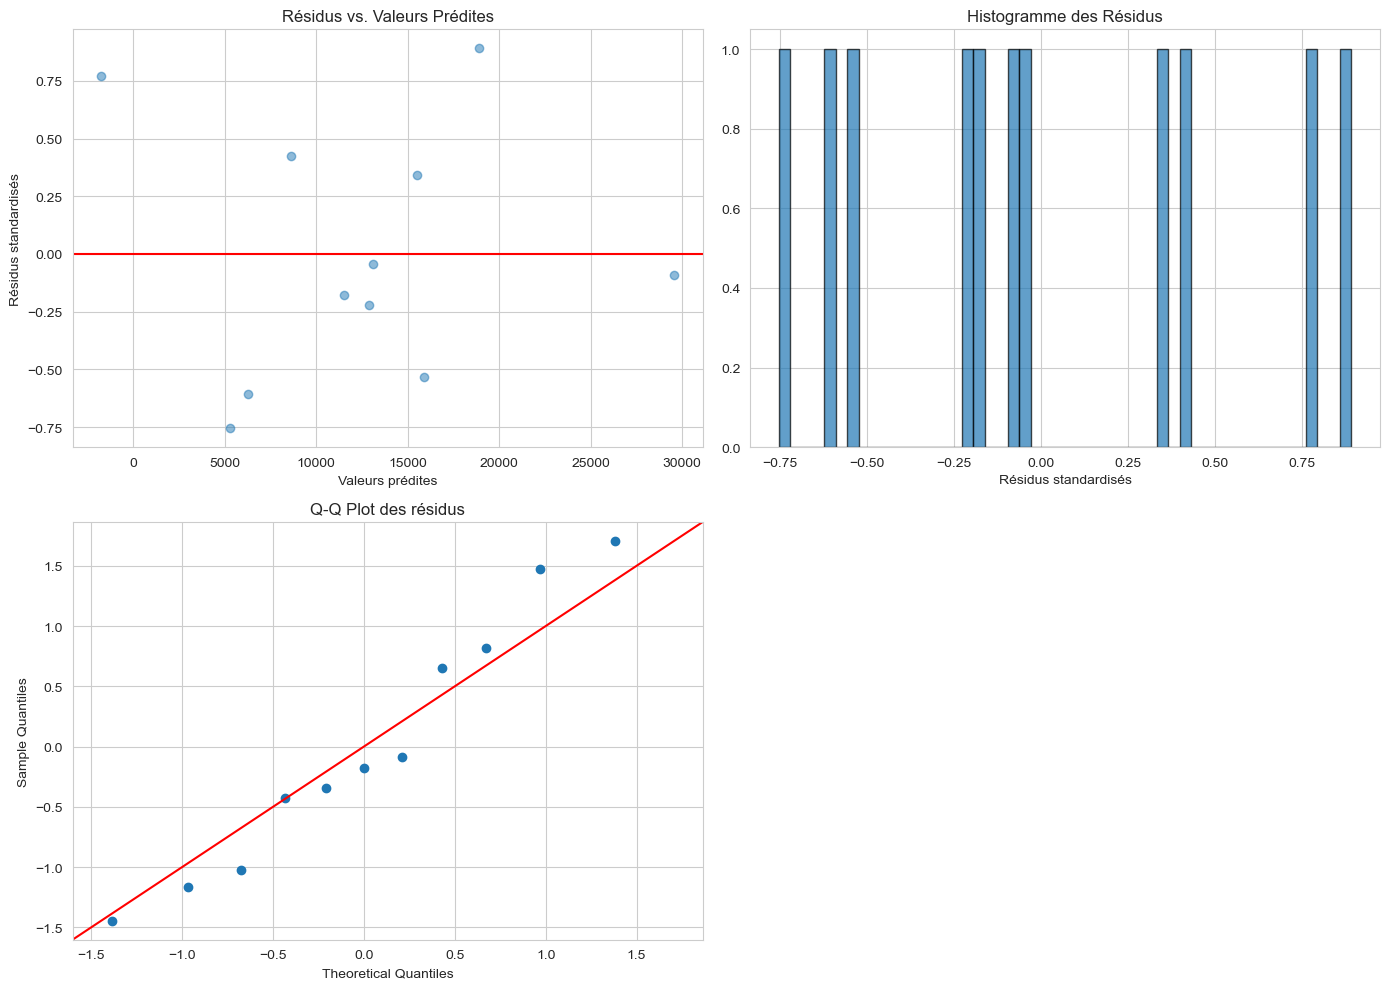

In [40]:
#### Modélisation de l’abondance en crabe légalement pêchable :
# Moyenne nombre de crabe legalement capturable
meanlegal = survey.groupby('annee').agg({'legal_male': 'sum'}).reset_index()
# Salinité moyenne
meansalinity = salinite.groupby('annee').agg({'salinite': 'mean'}).reset_index()
# Fullness moyenne 90-100%
meanfull = fullness.groupby('Year').agg({'90-100%_fullness': 'sum'}).reset_index()
# Moyenne 1-29% fullness
mean29 = fullness.groupby('Year').agg({'1-29%_fullness': 'sum'}).reset_index()

survey2 = meansalinity.copy()
survey2.columns = ['Year', 'salinity']

survey2['temp'] = meanTemp['temp'][:14].values
# Nb males
Nbmale = survey.groupby('annee').agg({'all_male': 'sum'}).reset_index()
# Nb femelle
Nbfemale = survey.groupby('annee').agg({'all_female': 'sum'}).reset_index()
survey2 = survey2.iloc[3:].reset_index(drop=True)
# Survey2
survey2['meansex'] = Nbfemale['all_female'][:11].values / Nbmale['all_male'][:11].values
survey2['full'] = meanfull['90-100%_fullness'][:11].values
survey2['f29'] = mean29['1-29%_fullness'][:11].values
survey2['legalmale'] = meanlegal['legal_male'][:11].values
# Modele pour l'abondance en male legalement capturable
X = sm.add_constant(survey2[['full', 'f29', 'meansex', 'temp', 'salinity']])
Y = survey2['legalmale']

mod_legal_male = sm.OLS(Y,X).fit()
print(mod_legal_male.summary())

plot_diagnostiques(mod_legal_male)

survey2_variables = [col for col in survey2.columns if col != "legalmale"]
print(survey2_variables)

for variable in survey2_variables :
  plt.figure(figsize=(10, 4))
  sns.regplot(data=survey2, x=variable, y='legalmale', color='#123456', scatter_kws={'s':20})
  plt.xlabel(variable)
  plt.ylabel('legalmale')
  plt.show()
  correlation = survey2['legalmale'].corr(survey2[variable])
  print(variable +  str(correlation))

# Salinité temperature et f29 non linéaire.
# Ajout de termes quadratiques pour la salinité et la temperature

survey2["temp_sqrt"] = survey2["temp"]**2
survey2["salinity_sqrt"] = survey2["salinity"]**2


X = sm.add_constant(survey2[['full', 'f29','meansex', 'temp', 'salinity', 'temp_sqrt', 'salinity_sqrt']])
Y = survey2['legalmale']

mod_legal_male_2 = sm.OLS(Y, X).fit()
print(mod_legal_male_2.summary())
plot_diagnostiques(mod_legal_male_2)
# Full a un effet significatif sur l'abondance en crabes legalement pechable

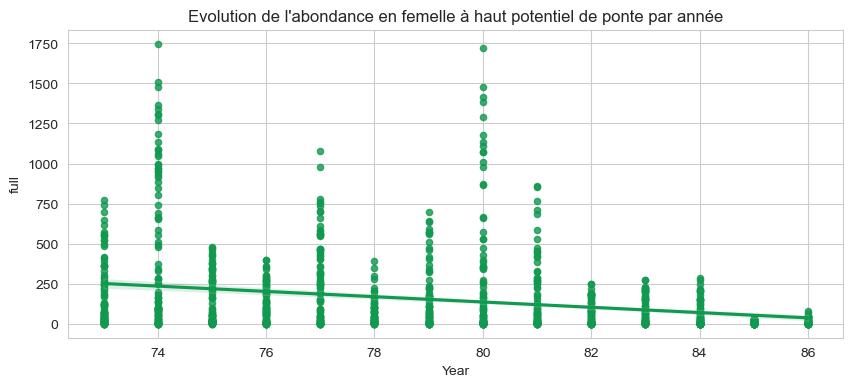

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   full   No. Observations:                 1170
Model:                            GLM   Df Residuals:                     1155
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0056e+05
Date:                Wed, 01 Nov 2023   Deviance:                   1.9506e+05
Time:                        15:51:55   Pearson chi2:                 1.95e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7893      0.014    553.253

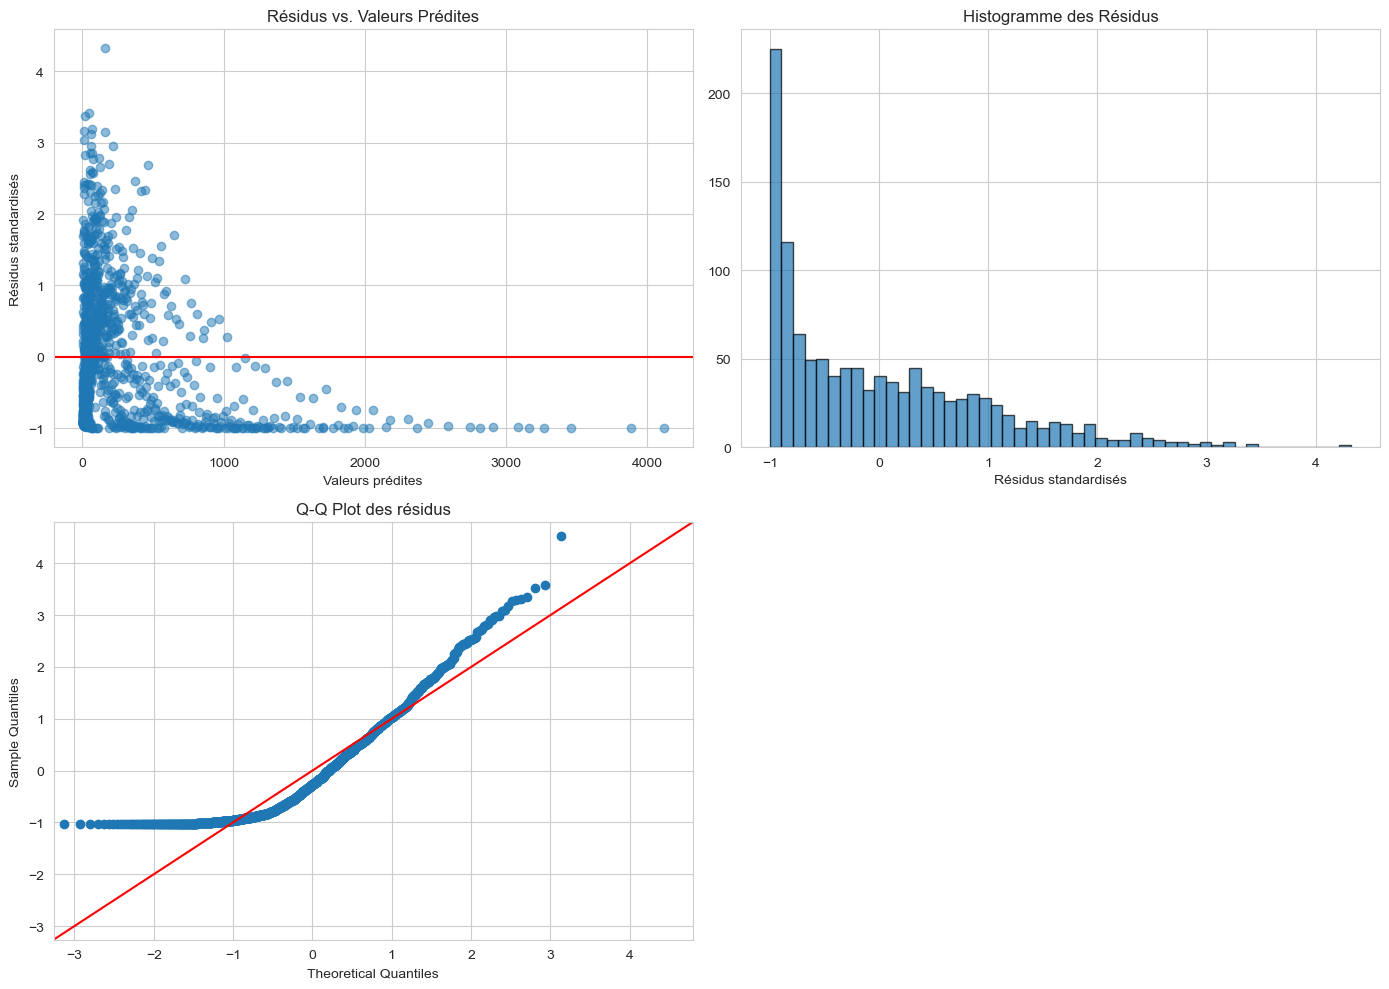

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   full   No. Observations:                 1170
Model:                            GLM   Df Residuals:                     1155
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6269.0
Date:                Wed, 01 Nov 2023   Deviance:                       2150.8
Time:                        15:51:55   Pearson chi2:                 1.07e+03
No. Iterations:                    28   Pseudo R-squ. (CS):             0.7385
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.5649      0.192     65.375

In [41]:
#### Evolution de l’abondance en femelle avec un haut potentiel de ponte :
fullness['Year'] = fullness['Year'].astype('category')
fullness.columns = ['Year', 'Size','0','1-29','30-59','60-89','full']
fullness['Year'] = fullness['Year'].cat.as_ordered()

formula = 'full ~ C(Year) + Size'

plt.figure(figsize=(10, 4))
sns.regplot(data=fullness, x='Year', y='full', color='#129950', scatter_kws={'s':20})
plt.xlabel("Year")
plt.ylabel("full")
plt.title("Evolution de l'abondance en femelle à haut potentiel de ponte par année")
plt.show()

mod_fullness = smf.glm(formula=formula, data=fullness, family=sm.families.Poisson()).fit()
print(mod_fullness.summary())

dispersion = mod_fullness.deviance / mod_fullness.df_resid
print(dispersion)
# Dispersion elevée

mod_fullness = smf.glm(formula=formula, data=fullness, family=sm.families.NegativeBinomial()).fit()
plot_diagnostiques(mod_fullness)
print(mod_fullness.summary())

